# Set-up

## Globals

In [132]:
# --- Standard library ---
import sys
import os

# --- Scientific computing ---
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# --- Network science ---
import networkx as nx

# --- Data handling and visualization ---
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")

from classifiers.features import get_degrees, get_configuration_probabilities_feature
from classifiers.features import get_distances, get_configuration_distances_feature, get_distance_ratios_feature
# from classifiers.features import get_labels, format_feature_matrix
from classifiers.logreg import *
from data.observations import get_preprocessed_data

In [133]:
SYSTEM = "LFR_gamma-3.5"
LAYERS = [1, 2]
REP = 1

THETAS = np.linspace(0.05, 0.95, 37, endpoint=True)
THETA = 0.5

## Loading cache and applying transformations

In [134]:
cache = get_preprocessed_data(SYSTEM, LAYERS, THETA, REP, ROOT="../../data/input/preprocessed/synthetic/")
cache.embeddings = cache.renormalize()
cache.embeddings = cache.align_centers()

# Precomputing features

In [135]:
edges = cache.observed_edges.copy()
edges.update(cache.unobserved_edges)

In [136]:
# distances_G, distances_H = get_distances(cache.embeddings, edges.keys())
# distances = get_configuration_distances_feature(distances_G, distances_H, zde_penalty=0.1)

distances_G, distances_H = get_degrees(cache.remnants, edges.keys())
distances = get_configuration_probabilities_feature(distances_G, distances_H)

In [137]:
df = pd.DataFrame({
    "edge": edges.keys(),
    "layer_actual": edges.values(),
    # "distance_G": distances_G,
    # "distance_H": distances_H,
    "distances": distances,
})

## Transformations, melts, and pivots

In [138]:
# Notating TTS
df["tts"] = [
    "Train" if row[1]["edge"] in cache.observed_edges else "Test"
    for row in df.iterrows()
]

normalizer = max(np.abs(df.distances.min()), df.distances.max())
df["distances_minmax"] = df["distances"].apply(lambda x: x / normalizer)

In [139]:
# Melting main quantitative variables
df_melted = df.melt(
    id_vars=["edge", "layer_actual", "tts"],
    value_vars=["distances", "distances_minmax"],
    var_name="distance_layer", value_name="distance_value"
)

In [140]:
df_melted = df_melted.replace({
    # "distance_G": "G",
    # "distance_H": "H",
    "distances": "Configuration",
    "distances_minmax": "Configuration (MinMax normalized)",
})

# Coefficient Analysis

## Sign and Magnitude

<Figure size 640x480 with 0 Axes>

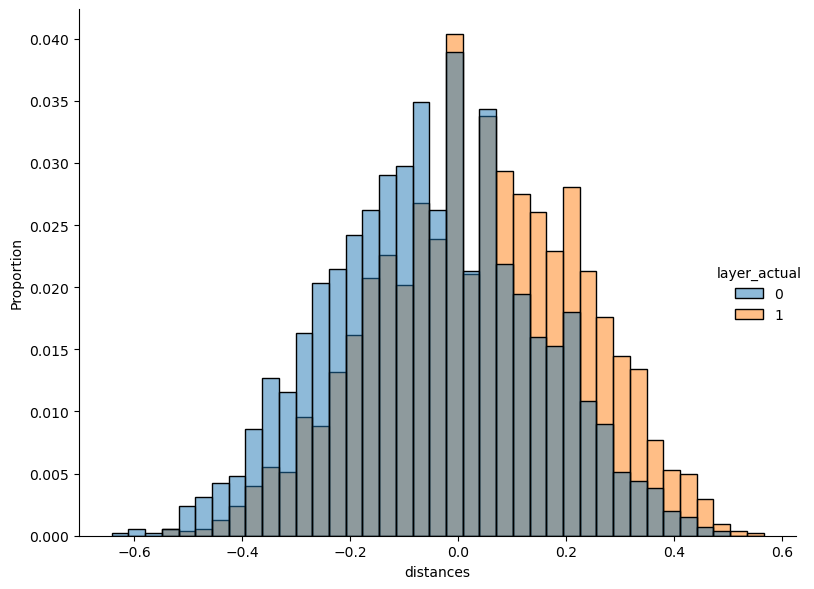

In [141]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distances",
    hue="layer_actual",
    height=6, aspect=1.2,
    stat="proportion"
)

# Axes configuration

# Figure-level attributes

# Save plot
plt.tight_layout()